<a href="https://colab.research.google.com/github/angelminsua/python/blob/main/regresionRNA14.10.2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.6.0
/content
dataset sin normalizar=    StreamPatronage  TrafficFlowRate  ...  PreviousPatronage  BusTime
0                1       118.333333  ...                  6      504
1               11       168.000000  ...                 11      743
2               10       216.222222  ...                  9      632

[3 rows x 7 columns]
x_df=        StreamPatronage  TrafficFlowRate  ...  AccumulatedRainfall  PreviousPatronage
0                    1       118.333333  ...                  0.0                  6
1                   11       168.000000  ...                  0.0                 11
2                   10       216.222222  ...                  0.0                  9
3                   26       330.952381  ...                  0.0                 12
4                   13       413.111111  ...                  0.0                 19
...                ...              ...  ...                  ...                ...
21586               20       467.222222  ...                  

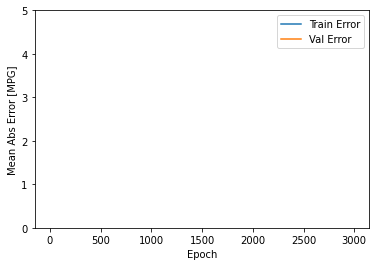

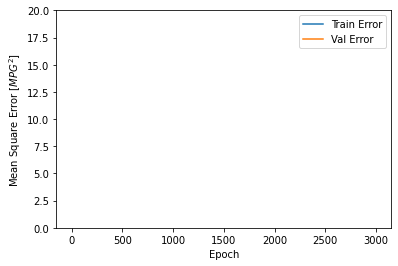

135/135 - 0s - loss: 7143.5117 - mae: 66.8828 - mse: 7143.5117
Testing set Mean Abs Error: 66.88 MPG


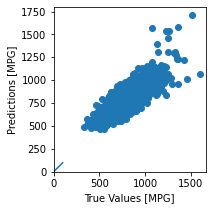

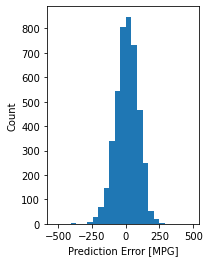

r_square = 0.6572530162585211


In [31]:

from keras.models import Sequential
from keras import layers
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Multilayer Perceptron (MLP): https://www.pyimagesearch.com/2019/01/21/regression-with-keras/
def create_mlp(dim, regress=False):
	# define our MLP network
	model = Sequential()
	model.add(layers.Dense(50, input_dim=dim, activation="relu"))
	model.add(layers.Dense(25, activation="relu"))
	# check to see if the regression node should be added
	if regress:
	  model.add(layers.Dense(1, activation="linear"))
	
	optimizer = tf.keras.optimizers.RMSprop(0.001) #parametro que se puede cambiar para mejorar 
	model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
	return model

#alternativa al metodo anterior
"""
def build_model():
  model = Sequential([layers.Dense(99, activation='relu', input_shape=[len(train_dataset.keys())]),layers.Dense(64, activation='relu'),layers.Dense(1)])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
"""

print(tf.__version__)
!pwd

dataset = pd.read_excel('df_datos_regresion_googleColab.xlsx', sheet_name='Sheet1')
print("dataset sin normalizar=", dataset.head(3))

# dividimos el set de datos en un set de entrenamiento y otro de pruebas. Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

"""
train_dataset = dataset.sample(frac=0.8,random_state=0)  # train_data es de tipo DataFrame
print("angel==================================================================", len(train_dataset.keys()))
test_data = dataset.drop(train_dataset.index) # test_data es de tipo DataFrame
print("test_data=", type(test_data))
train_labels = train_dataset.pop('BusTime') #devuelve la columna BusTime en forma de objeto Series y la elimina del dataframe train_data
#print("DF=======", train_data.head(5))
test_labels = test_data.pop('BusTime') #test_labels es de tipo Series. Hacemos lo mismo pero para el dataframe test_data (en la instrucción anterior fue para el dataframe train_data)
print("test_labels=", test_labels[:5])
"""

x_df = dataset.drop('BusTime', axis=1)
y_df= dataset['BusTime']
print("x_df=", x_df)
print("y_df=", y_df)


#normalizar dataset
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
scaler = scaler.fit(x_df)
x= scaler.transform(x_df)
print("x_df=", (x_df))
y = y_df.to_numpy()

from sklearn.model_selection import train_test_split
train_dataset, test_data, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state = 0) #train_dataset es X_train, test_data es X_test, train_labels es y_train, test_labels es y_test 
print("train_dataset.shape[1]==========================================", train_dataset.shape[1])

model = create_mlp(train_dataset.shape[1],True) #build_model()
model.summary()


#Entrenar a la modelo
#Entrene el modelo durante 1000 épocas y registre la precisión de entrenamiento y validación en el objeto history.

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 3000
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])

#Visualizar el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto history.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
#https://www.tensorflow.org/tutorials/keras/regression?hl=es-419
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error [MPG]')
plt.plot(hist['epoch'], hist['mae'],
          label='Train Error')
plt.plot(hist['epoch'], hist['val_mae'],
          label = 'Val Error')
plt.ylim([0,5])
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error [$MPG^2$]')
plt.plot(hist['epoch'], hist['mse'],
          label='Train Error')
plt.plot(hist['epoch'], hist['val_mse'],
          label = 'Val Error')
plt.ylim([0,20])
plt.legend()
plt.show()


#plot_history(history)

loss, mae, mse = model.evaluate(test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

test_predictions = model.predict(test_data).flatten()
#dibujamos las predicciones (cada punto debería dar a la misma altura en el eje x y en el y)
plt.subplot(1, 2, 1)
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

#Echemos un vistazo a la distribución de errores. Deberóa seguir una normal
error = test_predictions - test_labels
plt.subplot(1, 2, 2)
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")
plt.show()
"""
from keras import backend as K
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

r_square = coeff_determination (test_labels, test_predictions)
print("r_square =", r_square )   
"""

from sklearn.metrics import r2_score
r_square = r2_score(test_labels, test_predictions)
print("r_square =", r_square )